In [39]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [40]:
w, h = 1280, 720
img_size = (w, h) # image size
nw, nh = 9, 6

In [41]:
def read_img(fname):
    # return cv2.imread(fname)
    return cv2.cvtColor(
        cv2.imread(fname),
        cv2.COLOR_BGR2RGB
    )

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [42]:
def find_corners(img):
    return cv2.findChessboardCorners(
        grayscale(img), (nw, nh), None
    )

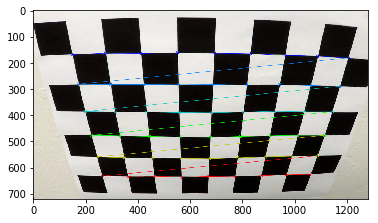

In [43]:
cal2 = read_img('camera_cal/calibration2.jpg')
success, corners = find_corners(cal2)
if success:
    cal2_copy = cal2.copy() # drawChessboardCorners modifies its parameter
    cv2.drawChessboardCorners(cal2_copy, (nw, nh), corners, True)
    plt.imshow(cal2_copy)

In [46]:
# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

objp = np.zeros((nw * nh, 3), np.float32)
objp[:,:2] = np.mgrid[0:nw, 0:nh].T.reshape(-1, 2) # x, y coordinate

for i in range(1, 21):
    img = read_img('camera_cal/calibration{}.jpg'.format(i))
    success, corners = find_corners(img)

    if success == True:
        imgpoints.append(corners)
        objpoints.append(objp)

In [47]:
# Calibrate camera
img_size1 = (cal2.shape[1], cal2.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, img_size, None, None
)

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

(1280, 720) (1280, 720)


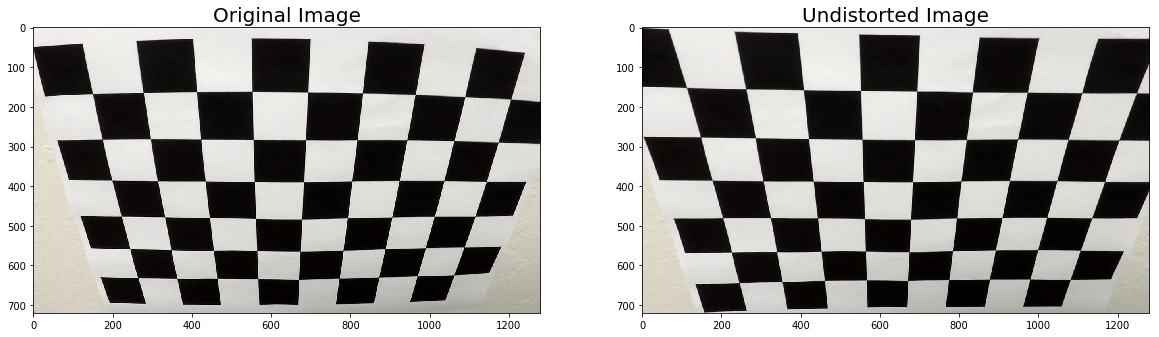

In [48]:
cal2_und = undistort(cal2)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cal2)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(cal2_und)
ax2.set_title('Undistorted Image', fontsize=20)


# plt.imshow(test1)

In [49]:
def warp(img, src, dst):
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size) # , flags=cv2.INTER_LINEAR)
    return warped, M, Minv

[(450, 0), (830, 0), (450, 720), (830, 720)]
...


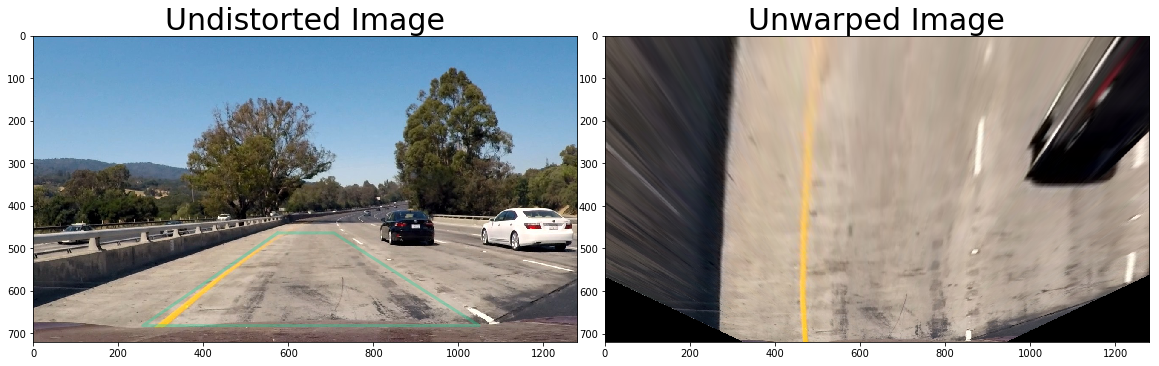

In [52]:
img3 = read_img('test_images/test1.jpg')


# define source and destination points for transform
src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])
dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])
print([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])
exampleImg_unwarp, M, Minv = warp(img3, src, dst)

# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img3)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(exampleImg_unwarp)
ax2.set_title('Unwarped Image', fontsize=30)

print('...')



In [159]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

In [151]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [152]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0.7, 1.3)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

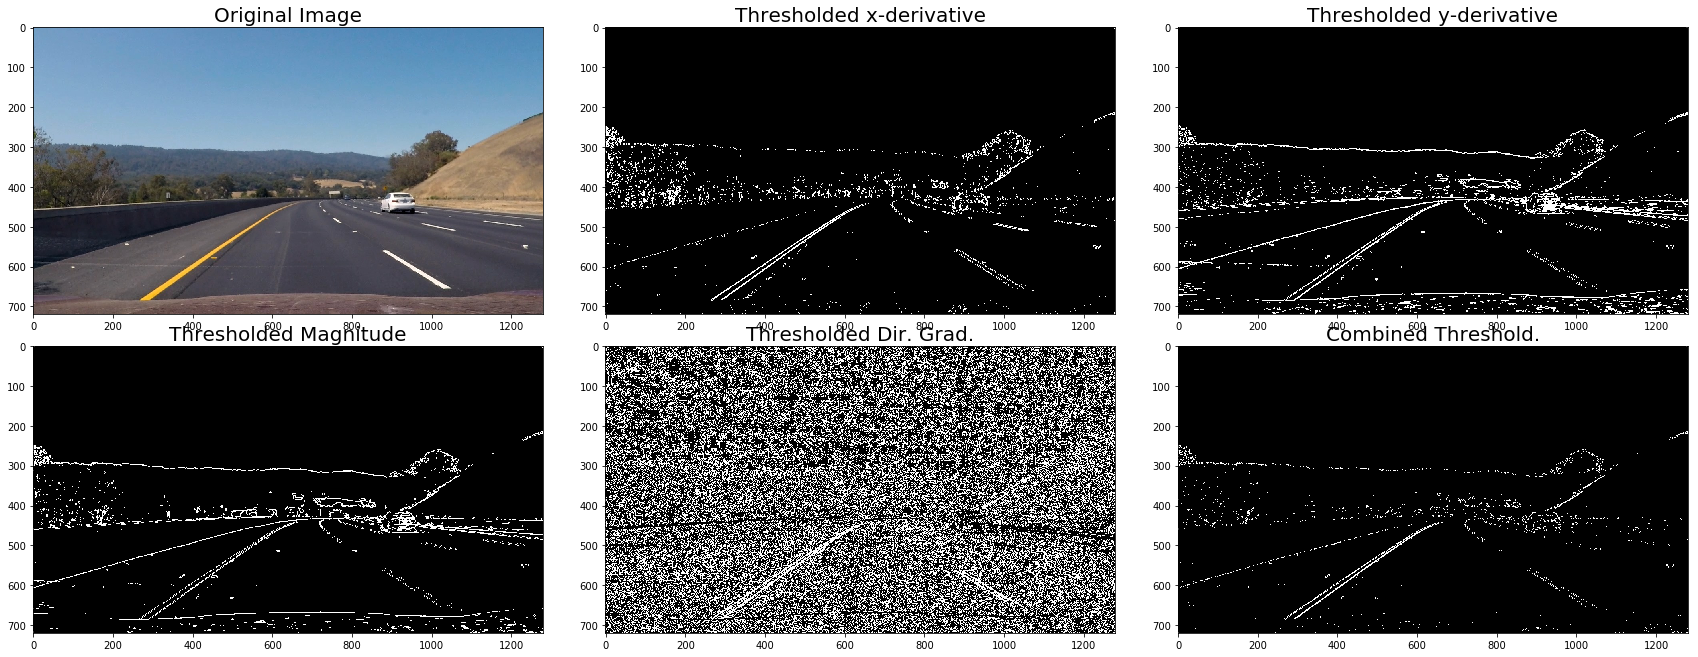

In [160]:
img3 = read_img('test_images/test3.jpg')
gradx = abs_sobel_thresh(img3, 'x')
grady = abs_sobel_thresh(img3, 'y')
mag_binary = mag_thresh(img3)
dir_binary = dir_threshold(img3)

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1


f, axs = plt.subplots(2, 3, figsize=(24, 9))
f.tight_layout()
axs[0][0].imshow(img3)
axs[0][0].set_title('Original Image', fontsize=20)
axs[0][1].imshow(gradx, cmap='gray')
axs[0][1].set_title('Thresholded x-derivative', fontsize=20)
axs[0][2].imshow(grady, cmap='gray')
axs[0][2].set_title('Thresholded y-derivative', fontsize=20)
axs[1][0].imshow(mag_binary, cmap='gray')
axs[1][0].set_title('Thresholded Magnitude', fontsize=20)
axs[1][1].imshow(dir_binary, cmap='gray')
axs[1][1].set_title('Thresholded Dir. Grad.', fontsize=20)
axs[1][2].imshow(combined, cmap='gray')
axs[1][2].set_title('Combined Threshold.', fontsize=20)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

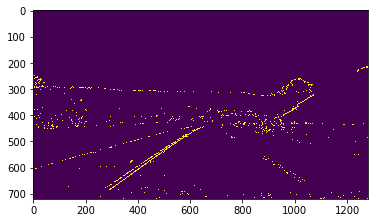

In [175]:
combined_grad = np.zeros_like(dir_binary)
combined_grad[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(combined_grad)

In [109]:
def print_channels(imgs, labels):
    f, axs = plt.subplots(1, 3, figsize=(20,10))
    for i in range(3):
        axs[i].set_title(labels[i], fontsize=20)
        axs[i].imshow(imgs[i], cmap='gray')

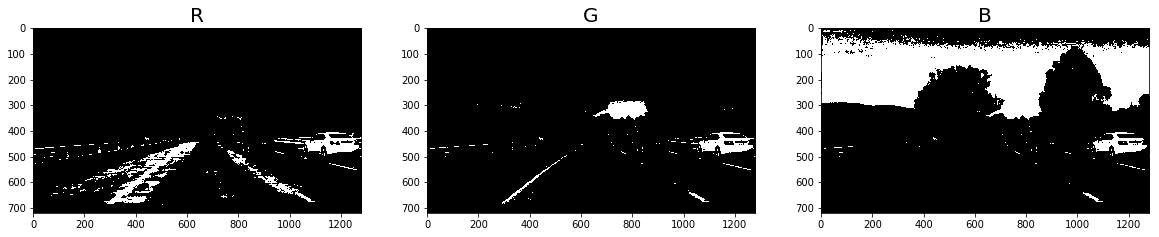

In [114]:
def rgb_channels(img):
    images = []
    for i in range(3):
        im = img[:,:,i]
        binary = np.zeros_like(im)
        binary[(im > 200) & (im <= 255)] = 1
        images.append(binary)
    return images

print_channels(rgb_channels(img3), ['R','G','B'])

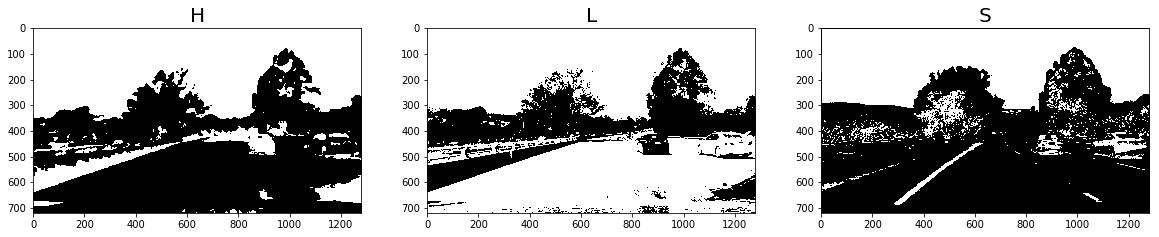

In [115]:
def hls_channels(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    images = []
    for i in range(3):
        im = hls[:,:,i]
        binary = np.zeros_like(im)
        binary[(im > 90) & (im <= 255)] = 1
        images.append(binary)
    return images

print_channels(hls_channels(img3), ['H','L','S'])

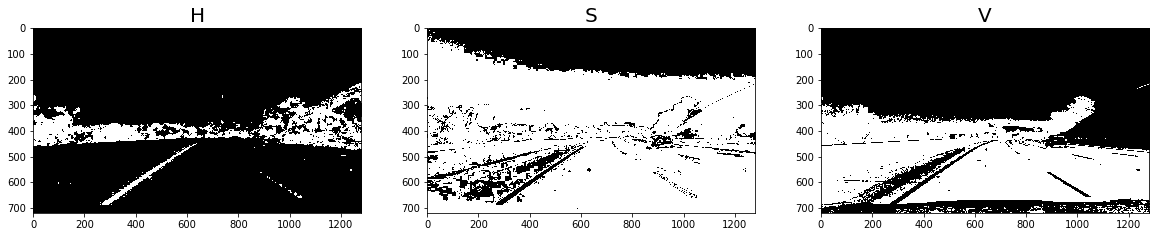

In [162]:
def hsv_channels(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    images = []
    for i in range(3):
        im = hsv[:,:,i]
        binary = np.zeros_like(im)
        binary[(im > 15) & (im <= 100)] = 1
        images.append(binary)
    return images

print_channels(hsv_channels(img3), ['H','S','V'])

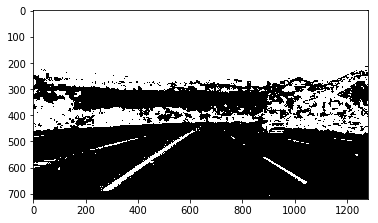

In [180]:
def combine_colors(img):
    [r,g,b] = rgb_channels(img)
    s = hls_channels(img)[2]
    h = hsv_channels(img)[0]
    combined = np.zeros_like(r)
    combined[((r == 1) & (g == b)) | ((s == 1) & (h == 1))] = 1
    return combined
    
combined_colors = combine_colors(img3)
plt.imshow(combined_colors, cmap='gray')

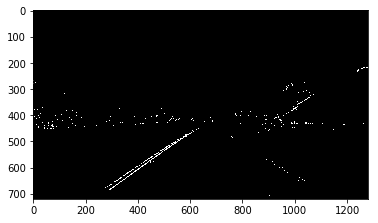

In [181]:

combined_both = np.zeros_like(combined_colors)
combined_both[((combined_colors == 1) | (combined_grad == 1))] = 1
plt.imshow(combined_both, cmap='gray')